 **심층 신경망 훈련하기**


아주 복잡한 문제를 다뤄야 할 때, 심층 신경망 훈련이 필요함

심층 신경망을 훈련하는 것은 쉬운 일이 절대 아님
- **그레이디언트 소실**, **그레이디언트 폭주** 문제에 직면함
    - 아래쪽으로 갈수록 그레이디언트가 점점 작아지거나 커지는 현상임
    - 두 현상 모두 하위층을 훈련하기 매우 어렵게 만듦
- 훈련 데이터가 충분하지 않거나 레이블을 만드는 작업에 비용이 너무 많이 들 수 있음
- 훈련이 극단적으로 느려질 수 있음
- 과대적합될 위험이 있음
    - 훈련 샘플이 충분하지 않거나 잡음이 많은 경우에 특히

# 그레이디언트 소실과 폭주 문제

- 경사 하강법 단계에서 그레이디언트를 사용하여 각 파라미터를 수정함

하지만 하위층으로 진행될수록 그레이디언트가 점점 작아지는 경우가 많음
- 이 문제를 **그레이디언트 소실 (vanishing gradient)**이라고 함

어떤 경우에는 반대 현상이 일어남
- 그레이디언트가 점점 커져서 비정상적으로 큰 가중치로 갱신됨
- 이 문제를 **그레이디언트 폭주 (exploding gradient)**이라고 함
- 순환 신경망에서 주로 나타남
---
일반적으로 불안정한 그레이디언트는 심층 신경망 훈련을 어렵게 만듦

---
그레이디언트를 불안정하게 만드는 원인
- 시그모이드 활성화 함수와 가중치 초기화 방법(평균이 0이고 표준편차가 1인 정규분포)의 조합 때문에 2000년 초까지 심층 신경망은 거의 방치되었음
- 출력의 분산이 입력의 분산보다 더 큼
- 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져 높은 층에서는 활성화 함수가 0이나 1로 수렴함
- 로지스틱 함수의 평균이 0이 아니고 0.5라는 사실 때문에 더 나빠짐


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

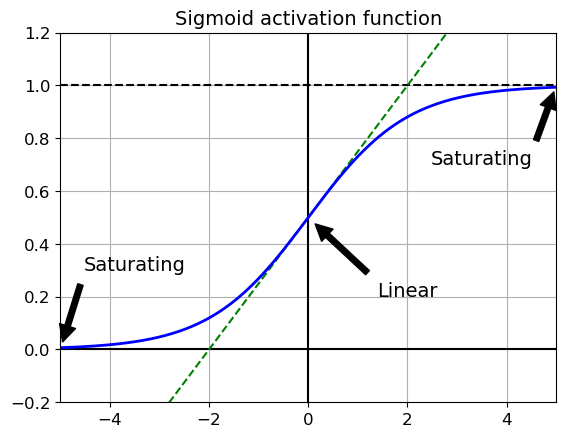

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("sigmoid_saturation_plot")
plt.show()

1. 평균이 0이 아닌 0.5라는 점
2. 입력이 커지면 0이나 1로 수렴해 기울기가 0에 매우 가까워지는 점

<font color="blue">따라서 역전파가 될 때 사실상 신경망으로 전파할 그레이디언트가 거의 없고 조금 있는 그레이디언트는 최상위층에서부터 역전파가 진행되면서 점차 약해져서 실제로 아래쪽 층에는 아무것도 도달하지 않게 됨</font>

## 글로럿과 He 초기화

글로럿과 벤지오의 완화하는 방법
- 예측할 때는 정방향으로 역전파할 때는 역방향으로 양방향 신호가 적절하게 흘러야함
- 신호가 죽거나 폭주 또는 소멸하지 않게 해야함
- 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장함
- 역방향에서 층을 통과하기 전과 후의 그레이디언트 분산이 동일해아 함
- 입력과 출력 연결 개수(층의 **팬-인(fan-in) 팬-아웃(fan-out)**)같지 않다면 이 두 가지를 보장할 수 없음
---
- 클로럿과 벤지오는 실전에서 매우 잘 작동한다고 입증된 대안을 제안함
- 아래 식으로 연결 가중치를 무작위 초기화하는 것임
- 이 식에서 $fan_{{avg}}=(fan_{{in}}+fan_{{out}})/2$임
    - 이 초기화 전략을 **세이비어 초기화** 또는 **글로럿 초기화**라고 부름

**글로럿 초기화(로지스틱 활성화 함수를 사용할 때)**

평균이 0이고 분산이 $\sigma^2=\frac{1}{fan_{{avg}}}$인 정규 분포

또는 $r = \sqrt{\frac{3}{fan_{{avg}}}}$ 일 때 -r과 +r 사이의 균등분포

$fan_{avg}$를 $fan_{in}$으로 바꾸면 **르쿤 초기화**가 됨
- 글로럿 초기화를 하면 훈련 속도를 상당히 높일 수 있음


일부는 분산의 스케일링이나 $fan_{avg}$또는 $fan_{in}$을 쓰는 것만 다름
- 균등분포의 경우 단순히 $r=\sqrt{3\sigma^2}$으로 계산함
- ReLU 활성화 함수에 대한 초기화 전략을 논문 저자의 이름을 따서 **He 초기화**라고 부름

|초기화 전략|활성화 함수|$ \sigma^2$ (정규분포)|
|---|---|---|
|글로럿|활성화 함수 없음, 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스|$1/fan_{avg}$|
|He|ReLU 함수와 그 변종들|$2/fan_{in}$|
|르쿤|SELU|$1/fan_{in}$|

케라스는 기본적으로 균등분포의 글로럿 초기화를 사용함
- `kernel_initializer="he_uniform"`이나 `kernel_initializer="he_normal"`로 바꾸어 He를 초기화 가능

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

케라스 초기화 방법이 이렇게 많음

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

- $fan_{in}$ 대신 $fan_{avg}$ 기반의 균등분포 He 초기화를 사용하고 싶으면 다음과 같이 Variance Scaling을 사용할 수 있음

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 수렴하지 않은 활성화 함수 

뉴런의 방식과 비슷한 시그모이드 활성화 함수가 최선의 선택일 것이라 생각했음
- 하지만 다른 활성화 함수가 더 잘 작동함
- 특히 ReLU 함수는 특정 양숫값에 수렴하지 않는다는 큰 장점이 있고 계산도 빠름
---
- ReLU 함수는 완벽하지 않음
- 죽은 ReLU가 있음
    - 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다는 의미에서 죽었따고 함
    - 큰 학습률을 사용하면 신경망의 뉴런 절반이 죽어 있기도 함
    - 뉴런의 가중치가 바뀌어 훈련 세트에 있는 모든 샘플에 대해 입력의 가중치 합이 음수가 되면 뉴런이 죽게 됨
    - 가중치 합이 음수면 ReLU 함수의 그레이디언트가 0이 되므로 경사 하강법이 더이상 작동하지 않음
---
이를 해결하고 자 **LeakyReLU**같은 ReLU 함수의 변종을 사용함

$\mbox{LeakyReLU}_\alpha(z)=\mbox{max}(\alpha z, z)$로 정의됨 
- $\alpha$가 새는 정도를 결정함
- 작은 기울기가 절대 죽지 않게 만들어줌

주어진 범위에서 $\alpha$를 무작위로 선택하고 테스트시에는 평균을 사용하는 **RReLU**도 평가했음
- 꽤 잘 작동하며 훈련하는 동안 학습되는 **PReLU**도 비교했음
- 대규모 데이터셋에서는 성능이 크게 앞섰지만 소규모 데이터셋에서는 훈련 세트에 과대적합될 위험이 있음

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

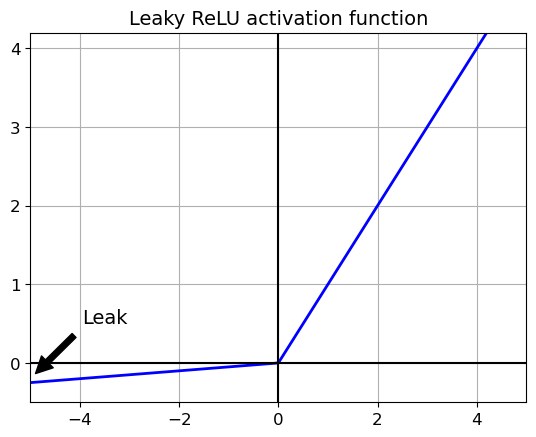

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

# save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

활성화 함수 종류

ELU라는 새로운 활성화 함수
- ReLU 변종의 성능을 앞질렀으며 훈련 시간 줄고 테스트 세트 성능도 더 높았음

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

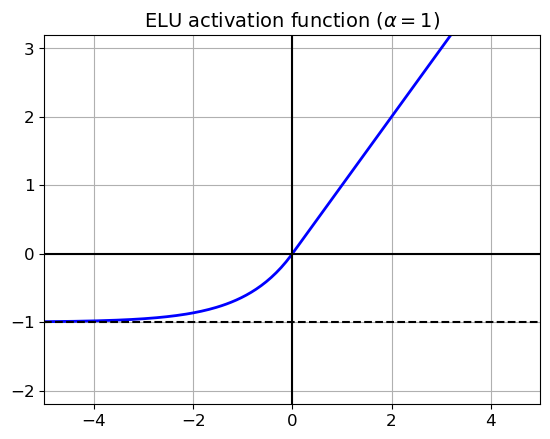

In [12]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("elu_plot")
plt.show()

이 함수는 몇 가지를 제외하고는 ReLU와 매우 비슷
- z < 0 일 때 음수값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워짐
    - 그레이디언트 소실 문제를 완화해줌
- z < 0 이어도 그레이디언트가 0이 아니므로 죽은 뉴런을 만들지 않음
- $\alpha = 1$이면 이 함수는 z=0에서 급격히 변동하지 않으므로 z=0을 포함해 모든 구간에서 매끄러워 경사 하강법의 속도를 높여줌
---
단점은 계산이느리다는 것
- 훈련하는 동안에는 수렴 속도가 빨라서 느린 계산이 상쇄되지만 테스트 시에 ELU를 사용한 네트워크보다 느릴 것임
---
2017년 SELU 활성화 함수가 나옴
- ELU보다 스케일이 조정된 활성화 함수임
- 신경망을 만들고 모든 은닉층이 SELU 활성화 함수를 사용한다면 네트워크가 자기 정규화 된다는 것을 보였음
- 훈련하는 동안 각 층의 출력이 평균 0과 표준편차 1을 유지하는 경향이 있음
- 그레이디언트 소실과 폭주 문제를 막아줌
- 모든 은닉층이 SELU 활성화 함수를 사용하면 네트워크가 자기 정규화됨
- 훈련하는 동안 각 층의 출력이 평균 0과 표준편차 1을 유지하는 경향이 있음
    - 그레이디언트 소실과 폭주 문제를 막아줌

**하지만 자기 정규화가 일어나기 위한 조건들이 있음**
1. 입력 특성이 반드시 표준화(평균0, 표준편차 1)되어야 함
2. 모든 은닉층의 가중치는 르쿤 정규분포 초기화로 초기화되어야 함. 케라스에서는 `kernel_initializer="lecun_normal"`로 설정함
3. 네트워크는 일렬로 쌓은 층으로 구성되어야 함
    - 순환 신경망이나 **스킵 연결 (와이드 & 딥 네트워크에서 건너뛰어 연결된 층)**과 같은 순차적이지 않은 구조에는 자기 정규화되는 것이 보장되지 않음
    

<font color="blue">모두 완전 연결 층일 때만ㄴ 자기 정규화가 됨</font>

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3009 - accuracy: 0.5947 - val_loss: 0.8804 - val_accuracy: 0.7152
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7928 - accuracy: 0.7408 - val_loss: 0.7071 - val_accuracy: 0.7690
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6787 - accuracy: 0.7783 - val_loss: 0.6406 - val_accuracy: 0.7894
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6198 - accuracy: 0.7962 - val_loss: 0.5883 - val_accuracy: 0.8062
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5823 - accuracy: 0.8065 - val_loss: 0.5574 - val_accuracy: 0.8176
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5554 - accuracy: 0.8138 - val_loss: 0.5346 - val_accuracy: 0.8250
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5351 - accuracy: 0.8201 - val_loss: 0.5155 - val_accuracy:

PReLU 사용하기

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])


In [19]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3527 - accuracy: 0.6047 - val_loss: 0.8973 - val_accuracy: 0.7284
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8003 - accuracy: 0.7476 - val_loss: 0.7103 - val_accuracy: 0.7672
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6811 - accuracy: 0.7795 - val_loss: 0.6408 - val_accuracy: 0.7918
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6198 - accuracy: 0.7992 - val_loss: 0.5840 - val_accuracy: 0.8108
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5799 - accuracy: 0.8105 - val_loss: 0.5515 - val_accuracy: 0.8188
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5512 - accuracy: 0.8171 - val_loss: 0.5283 - val_accuracy: 0.8252
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5299 - accuracy: 0.8232 - val_loss: 0.5097 - val_accuracy:

SELU

In [20]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)


In [21]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

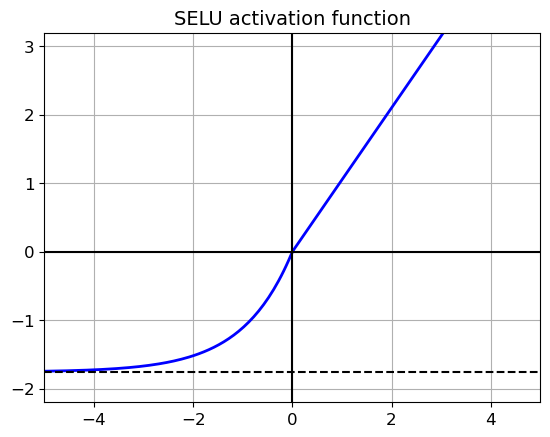

In [22]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("selu_plot")
plt.show()

평균 0과 표준편차 1이 유지되어야 함

In [23]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [24]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [28]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 20s 9ms/step - loss: 1.5869 - accuracy: 0.3728 - val_loss: 1.3128 - val_accuracy: 0.4786
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.9567 - accuracy: 0.6387 - val_loss: 0.7719 - val_accuracy: 0.6916
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7340 - accuracy: 0.7315 - val_loss: 0.7963 - val_accuracy: 0.7070
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6071 - accuracy: 0.7767 - val_loss: 0.5856 - val_accuracy: 0.7886
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5570 - accuracy: 0.7995 - val_loss: 0.5431 - val_accuracy: 0.8148


## 배치 정규화

ELU와 함께 He 초기화를 사용하면 훈련 초기 단계에서 그레이디언트 소실이나 폭주 문제를 크게 감소시킬 수 있지만 훈련하는 동안 다시 발생하지 않으리란 보장은 없음
- **배치 정규화** 기법이 추가됨
---
각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가함
- 입력을 원점에 맞추고 정규화한 다음 두 개의 새로운 파라미터로 결괏값의 스케일을 조정하고 이동시킴
- 하나는 스케일 조정에 다른 하나는 이동에 사용함
- 이러한 경우가 많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 표준화할 필요가 없음


**배치 정규화 알고리즘**

1. $\mu_B=\frac{1}{m_B}\sum^{m_B}_{i=1}x^{(i)}$
2. $\sigma_B^2=\frac{1}{m_B}\sum^{m_B}_{i=1}(x^{(i)}-\mu_B)^2$
3. $\hat{x}^{(i)}=\frac{x^{(i)}-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}$
4. $z^{(i)}=\gamma \otimes \hat{x}^{(i)}+\beta$

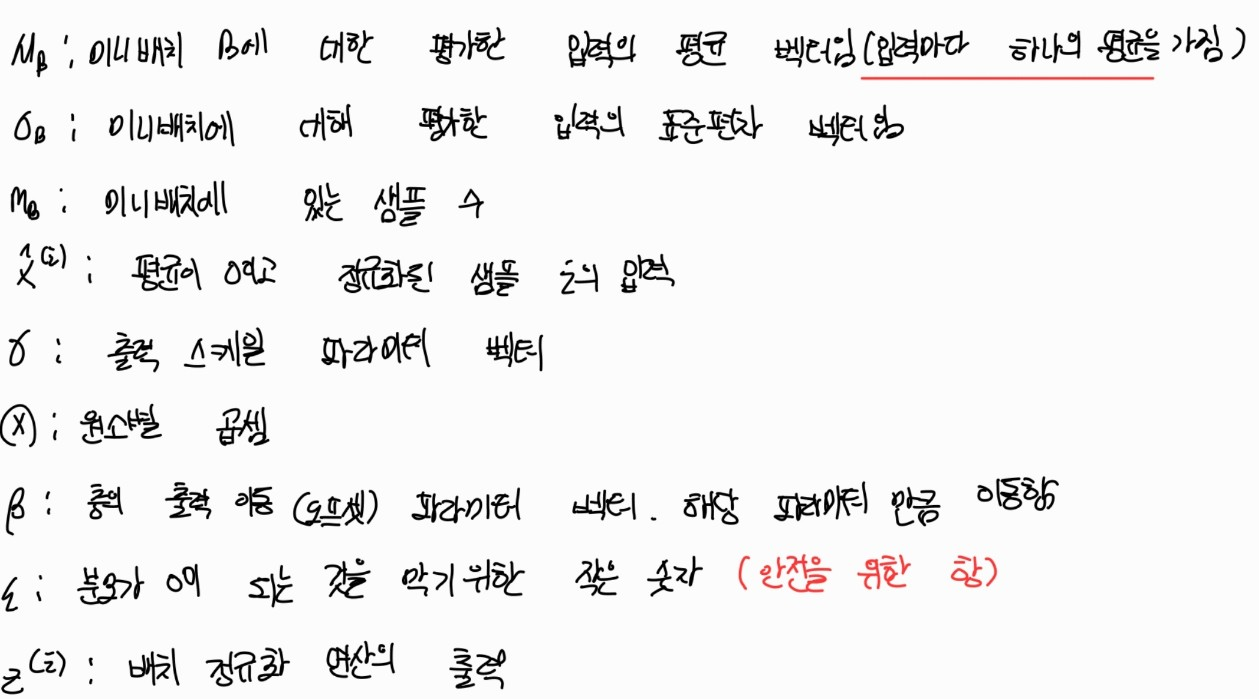

훈련하는 동안 입력을 정규화한 다음 스케일을 조정하고 이동시킴
- 테스트 시에는 어떻게 함?

테스트 시에는 입력의 평균과 표준편차를 계산할 수 없음
- 샘플의 배치를 사용한다 하더라도 매우 작거나 독립 동일 분포(IID) 조선을 만족하지 못할 수 있음
- 이런 배치 샘플에서 계산한 통계는 신뢰도가 떨어짐
---
방법으로 훈련이 끝난 후 전체 훈련 세트를 신경망에 통과시켜 배치 정규화 층의 각 입력에 대한 평균과 표준편차를 계산하는 것임
- 예측할 때 배치 입력 평균과 표준편차로 이 최종입력 평균과 표준편차를 대신 사용할 수 있음
- 대부분 훈련하는 동안 최종 통계를 추정함
- 케라스는 자동으로 학습됨


---
배치 정규화가 성능을 크게 향상 시킴
- 그레이디언트 소실 문제가 크게 감소하여 다른 활성화 함수를 사용할 수 있어짐
- 가중치 초기화에 네트워크가 훨씬 덜 민감해짐
- 큰 학습률을 사용하여 학습 과정의 속도를 크게 높일 수 있음
---
하지만 배치 정규화는 모델의 복잡도를 키우고 실행 시간 면에서도 손해임

**케라스로 배치 정규화 구현하기**

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")    
])

은닉층 두 개를 가진 작은 예제라 배치 정규화가 큰 도움이 되지 않을 수 있음
- 하지만 깊은 네트워크에서는 엄청난 차이를 만들 수 있음

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_110 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_111 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

배치 정규화 층은 입력마다 네 개의 파라미터 $\gamma$, $\beta$, $\mu$, $\sigma$를 추가함
- 마지막 두 개의 파라미터 $\mu, \sigma$는 이동 평균임
- 이 파라미터는 역전파로 학습이 되지 않기 때문에 'Non-trainable'파라미터로 분류함

In [32]:
# 첫 번째 배치 정규화 층의 파라미터를 살펴봄
# 두 개는 (역전파로) 훈련되고 두 개는 훈련되지 않음
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

케라스에서 배치 정규화 층을 만들 때 훈련하는 동안 매 반복마다 케라스에서 호출될 두 개의 연산이 함께 생성됨
- 이 연산이 이동 평균을 업데이트함

In [33]:
model.layers[1].updates

C:\Users\hansol\AppData\Local\Temp\ipykernel_10468\3873162892.py:1: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  model.layers[1].updates


[]